In [1]:
import sys

assert sys.version_info >= (3,7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Pegas Prodution - kitty kunt and coco ivy

## Importando o dataset

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")#tgz é um tipo de compatação diferente de zip
    tarball_csv = Path("datasets/housing/housing.csv")
    if  tarball_csv.is_file():
         return pd.read_csv(Path(tarball_csv))#por padrao separador: ,
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))#por padrao separador: ,


housing = load_housing_data()


In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()
#total_bedrooms = 20433, existem cerca de 277 instancias em que esse descritor é nulo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()
# ocean_proximity é o unico descritor do conjunto de dados que NÂO é do tipo numerico, mas sim STRING    

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()
# Em total_bedrooms os valores nulos foram ignorados pelo count

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Criando uma pasta para guardar imagens

In [8]:
IMAGES_PATH = Path("images/end_to_end_project") 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)#cria as pastas se nao existir, se existirem nao gera erro

def save_fig(fig_id, tight_layout= True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    # plt.savefig guarda o estado de execução e salva a ultima figura executada
    plt.savefig(path, format=fig_extension, dpi=resolution)

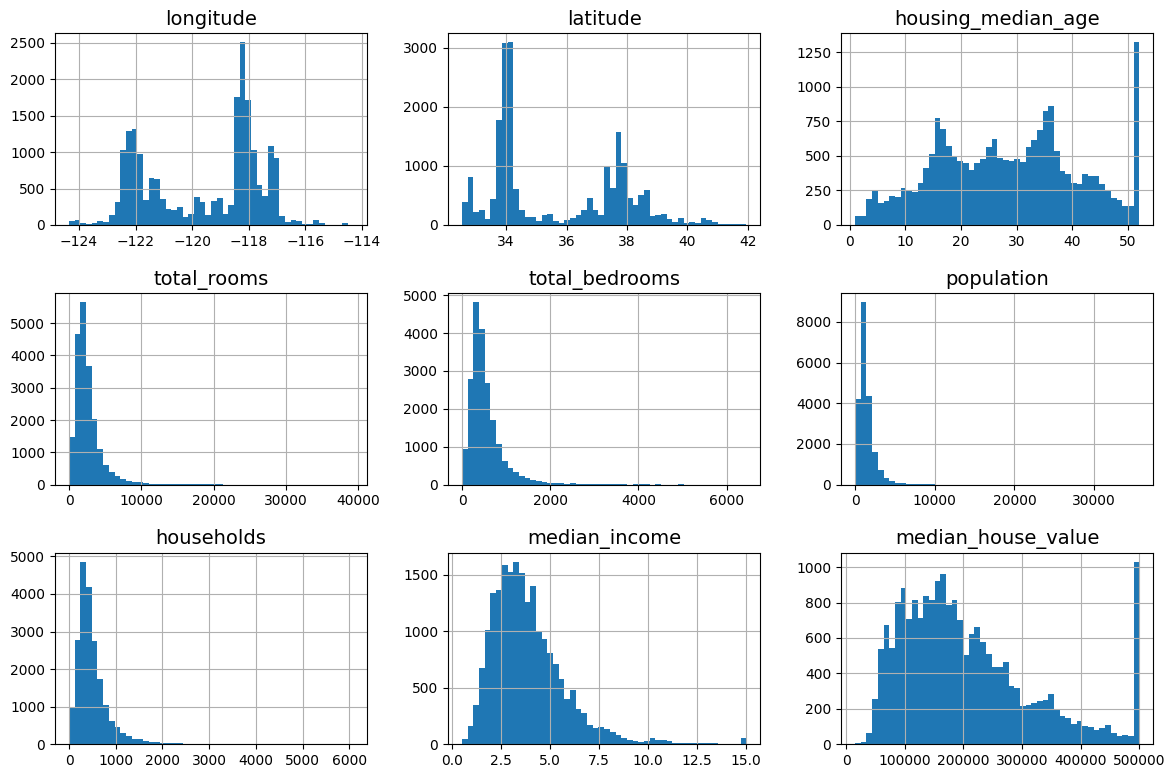

In [9]:
#plt.rc() é usado para criar parametros globais
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plot")
plt.show()

Criando o conjunto de teste

O codigo abaixo altera as amostras separadas para cada vez que o programa roda. E isso nao é bom, pois, em algum momento o codigo vai eventualmente passar por todo o conjunto.

In [10]:
import numpy as np

# Iremos separar uma parte para teste e uma para treinamento
# Um bom conjunto de teste é um parte embaralhada dos dados, para nao pegar conjunto fechados
def shuffle_and_split_data(data, test_ratio):
    len_data = len(data)
    shuffle_indices = np.random.permutation(len_data)
    #Embaralha os indices de 0 a len_data -> [100, 258, 47854, 0, 798, ...]

    test_set_size = int(len_data * test_ratio)
    #Determina o tamanho dos dados de test dos dados

    test_indices = shuffle_indices[:test_set_size]
    #Separa os primeiros identificadores para o conjunto test

    train_indices = shuffle_indices[test_set_size:]
    #O restante para o treino

    #.iloc() é um metodo da biblioteca pandas, localiza as instancias com base na posição 
    return data.iloc[train_indices], data.iloc[test_indices]


In [11]:
#Para garantir que np.random fixe os valores usaremos o comando a seguir, isso impede que os resultados variem a cada inicialização:
np.random.seed(42)
train_set, test_set = shuffle_and_split_data(housing,0.2)
print(f'Tamanho do conjunto treino: {len(train_set)}\nTamanho do conjunto teste: {len(test_set)}')

Tamanho do conjunto treino: 16512
Tamanho do conjunto teste: 4128


A np.random.seed(42) gera uma aletoriedade fixa para um conjunto de dados fixo. Se incrementar ou deletar instancias a semente geradora irá gerar resultados diferentes. Portanto, para um conjunto fixo mesmo se reiniciar o computador, para um conjunto fixo de dados, o resultado permanecera identico.

Uma maneira de contorna isso é utilizando algoritmo do tipo HASH. Esses algoritmos nao se alteram, e produzem sempre o mesmo resutado para as mesmas entradas. Bom para dados que podem ser incrementados ao decorrer do programa. Cada byte de um hash é definido de forma a garantir uma distribuição uniforme de dados.

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    #Verificando o ultimo byte do hash
    #A função hash é deterministica, e distribui os dados igualmente por todo o intervalo 0 a 255
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio
                                     
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5 ):
    ids=data[id_column]
    in_test_set = ids.apply(lambda _id: test_set_check(_id, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Para o uso do id como identificador: deve-se garantir que novos dados sejam adicionados ao final do tabela original e nao sobreponham qualquer outro dado, com isso garantimos a integridade da divisao teste e treino mantendo sempre os mesmo dados.


In [13]:
# Definindo um conjunto ID
# .reset_index() define o indice do elemento como um index e cria uma nova coluna com nome "index" por padrão
housing_with_id = housing.reset_index()
housing_with_id.info()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               20640 non-null  int64  
 1   longitude           20640 non-null  float64
 2   latitude            20640 non-null  float64
 3   housing_median_age  20640 non-null  float64
 4   total_rooms         20640 non-null  float64
 5   total_bedrooms      20433 non-null  float64
 6   population          20640 non-null  float64
 7   households          20640 non-null  float64
 8   median_income       20640 non-null  float64
 9   median_house_value  20640 non-null  float64
 10  ocean_proximity     20640 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


Caso nao for possivel garantir que os novos dados entrem ao final da tabela original e nao excluam nenhum linha, um abordagem diferente deve ser usada e outra caracteristica mais indivial deve ser usada. Por exemplo a latitude e longitude.

In [14]:
housing_with_id["id"] = housing['longitude']*1000 + housing['latitude']
housing_with_id.info()
train_set,test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               20640 non-null  int64  
 1   longitude           20640 non-null  float64
 2   latitude            20640 non-null  float64
 3   housing_median_age  20640 non-null  float64
 4   total_rooms         20640 non-null  float64
 5   total_bedrooms      20433 non-null  float64
 6   population          20640 non-null  float64
 7   households          20640 non-null  float64
 8   median_income       20640 non-null  float64
 9   median_house_value  20640 non-null  float64
 10  ocean_proximity     20640 non-null  object 
 11  id                  20640 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.9+ MB


Observa-se o aumento de memoria ao adicionar novos rotulos, cerca de 200kBytes por rotulo


Uma outra alternativa é usar bibliotecas ja prontas, como por exemplo a Scikit-Learn, divisao baseada na aleatoriedade

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

train_test_split(X, y, test_size, train_size, random_state, shuffle, stratify)

X: As features (variáveis de entrada) do conjunto de dados. Pode ser um DataFrame do pandas ou um array do NumPy.

y: O target (variável de saída ou rótulos).

test_size: Define a proporção do conjunto de dados que irá para o conjunto de teste. Pode ser um número entre 0.0 e 1.0 (ex: 0.2 para 20%) ou um número inteiro para o tamanho absoluto.

train_size: Semelhante ao test_size, define a proporção do conjunto de treino. É comum usar apenas um dos dois.

random_state: Um número inteiro para o gerador de números aleatórios. Usar um random_state fixo garante que a divisão seja a mesma toda vez que o código for executado, tornando seu trabalho reproduzível.

shuffle: Um valor booleano (True/False) que indica se os dados devem ser embaralhados antes da divisão. O padrão é True, o que é recomendado para evitar que a ordem dos dados influencie a divisão.

stratify: Usado para manter a proporção das classes (rótulos) do y nos conjuntos de treino e teste. Se você tem um conjunto de dados desbalanceado (ex: 90% de uma classe e 10% de outra), usar stratify=y garante que o conjunto de teste também terá aproximadamente 90% e 10% das classes, respectivamente.

É observado que a renda media é um dos fatores determinantes na venda de casas. Será realizado uma estratificação em relação a renda media (median income).
Por ser um dos fatores chaves nao é recomendado ter muitos estratos, para nao segmentar demais as faixas

C:\Users\Alfredo\AppData\Local\Temp\ipykernel_22628\3035598158.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)


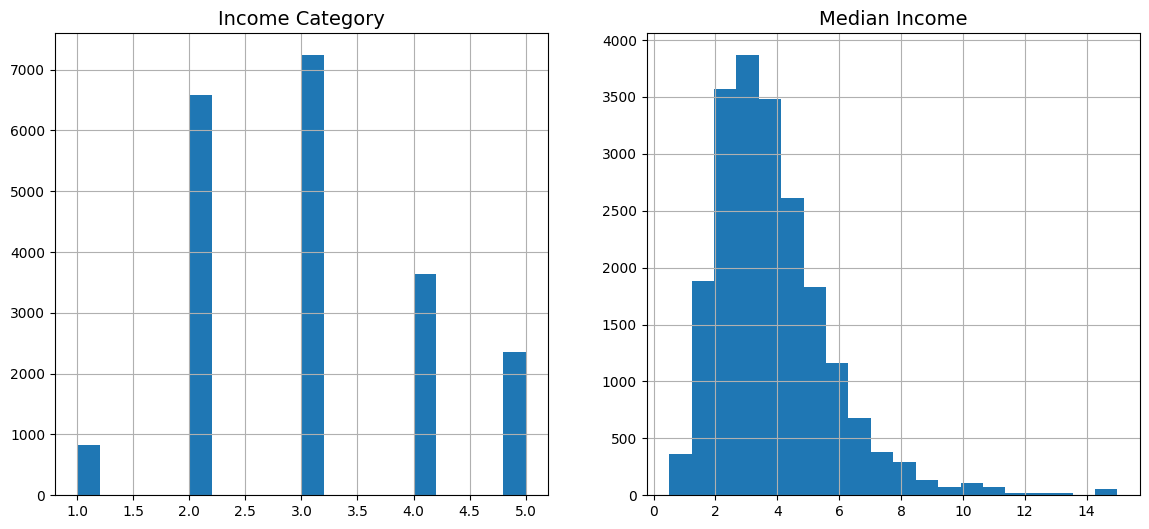

In [16]:

housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fig, ax = plt.subplots(1, 2, figsize=(14,6))
housing['income_cat'].hist(bins=20, ax=ax[0])
ax[0].set_title("Income Category")
housing['median_income'].hist(bins=20, ax=ax[1])
ax[1].set_title("Median Income")
plt.show()

O metodo StratifiedShuffleSplit (Divisão Embaralhada por Estratificação) da SkLearn realiza o calculo

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set_n = housing.loc[train_index]
    strat_test_set_n = housing.loc[test_index]
    strat_splits.append([strat_test_set_n, strat_train_set_n])

Se income_cat tem distribuição assim:

Categoria 1 → 40%

Categoria 2 → 30%

Categoria 3 → 20%

Categoria 4 → 10%

Mesmo após dividir em treino e teste:

Treino mantém aproximadamente 40%, 30%, 20%, 10%.

Teste também mantém aproximadamente 40%, 30%, 20%, 10%.

In [18]:
strat_test_set, strat_train_set = strat_splits[0]
(strat_train_set['income_cat'].value_counts()/len(strat_train_set)).sort_index()

income_cat
1.0    0.039789
2.0    0.318859
3.0    0.350594
4.0    0.176296
5.0    0.114462
Name: count, dtype: float64

Comparação entre Estratificação e Aleatoriedade na separação de dados

In [19]:
def proportions_income_data(data):
    return data['income_cat'].value_counts()/len(data)

train_set, test_set = train_test_split(housing, test_size= 0.2, random_state=42)

comparison_between_methods = pd.DataFrame({
    "Overall %" : proportions_income_data(housing),
    "Stratified %" : proportions_income_data(strat_train_set),
    "Random %" : proportions_income_data(train_set)
}).sort_index()
comparison_between_methods.index.name = "Income Category"
#ERRO RELATIVO = (ERRO_ATUAL - ERRO_ABS)/(ERRO_ABS)
comparison_between_methods["Strat. Error%"] =  (comparison_between_methods["Stratified %"] / (comparison_between_methods["Overall %"]) - 1)
comparison_between_methods["Rand. Error%"] = (comparison_between_methods["Random %"] / comparison_between_methods["Overall %"]) - 1

O metodo de estratificação, gerou uma divisao de dados mais proximo do conjuto original

In [20]:
(comparison_between_methods * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error%,Rand. Error%
Income Category,,,,,
1.0,3.98,3.98,3.92,-0.09,-1.61
2.0,31.88,31.89,32.17,0.00,0.90
3.0,35.06,35.06,35.19,0.00,0.38
4.0,17.63,17.63,17.44,-0.01,-1.11
5.0,11.44,11.45,11.28,0.02,-1.41


Apos a analise deve-se voltar os dados ao estado original

In [21]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5.0
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4.0
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3.0
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3.0
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY,3.0
...,...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN,2.0
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND,2.0
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN,4.0
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY,4.0


In [22]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [23]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042.0,597.0,1206.0,541.0,2.1135,90600.0,NEAR OCEAN
8707,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289,59400.0,INLAND
16634,-123.01,38.67,33.0,914.0,147.0,394.0,132.0,4.6875,246200.0,<1H OCEAN
9779,-122.03,37.60,24.0,2077.0,383.0,1488.0,389.0,4.5721,214700.0,NEAR BAY


In [24]:
housing = strat_train_set.copy()

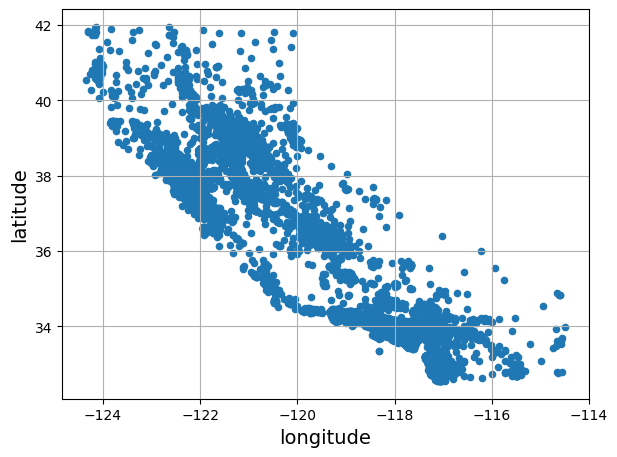

In [25]:
housing.plot(kind='scatter', y='latitude', x='longitude', grid=True)
save_fig('bad_visualization_plot')

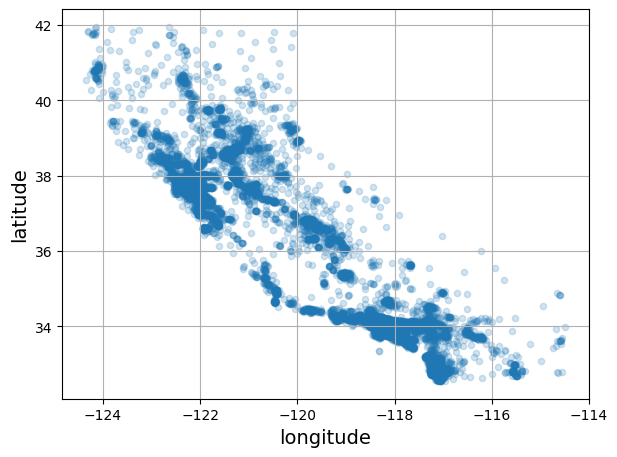

In [26]:
housing.plot(kind='scatter', y='latitude', x='longitude', grid=True, alpha=0.2)
save_fig("better_visualization")

<Axes: xlabel='longitude', ylabel='latitude'>

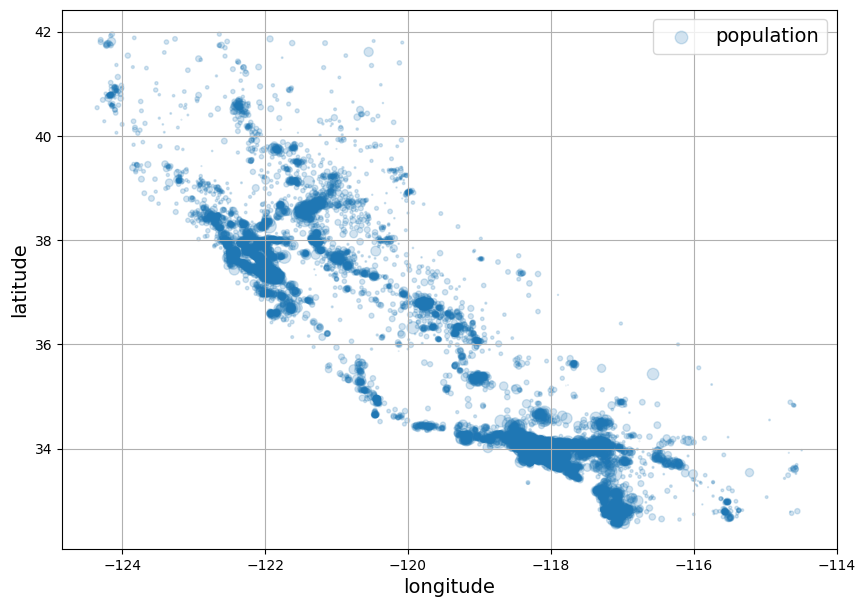

In [27]:
housing.plot(kind='scatter', y='latitude', x='longitude', grid=True, alpha=0.2,
             s=housing['population']/100, label='population', figsize=(10,7))

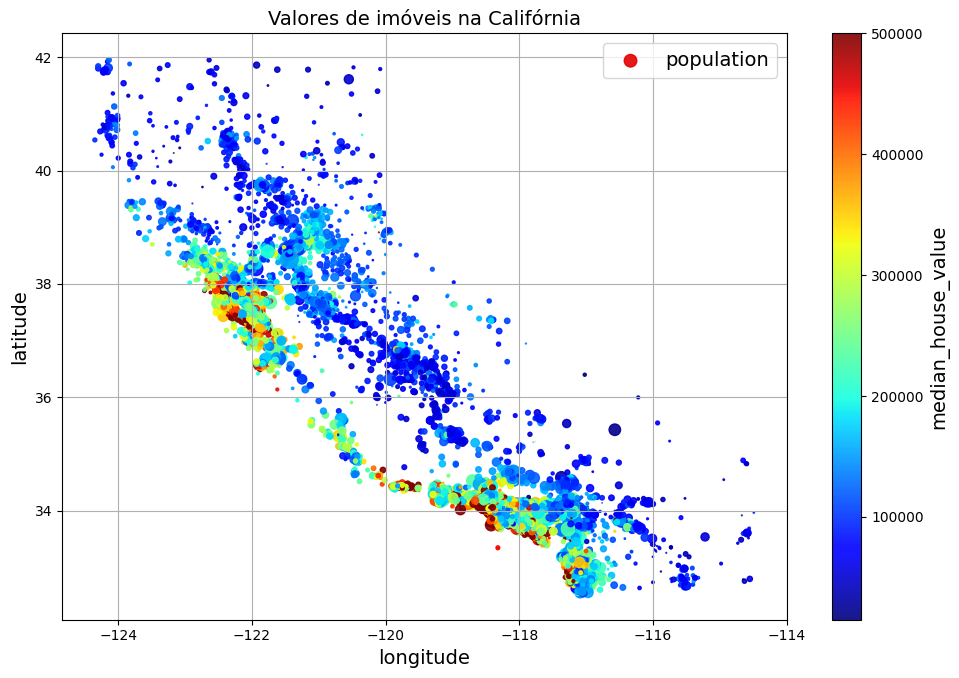

In [28]:
housing.plot(kind='scatter', y='latitude', x='longitude', grid=True, alpha=0.9,title="Valores de imóveis na Califórnia",
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value',cmap=plt.get_cmap('jet'), colorbar=True,sharex=False )
save_fig("prices_houses_in_california")

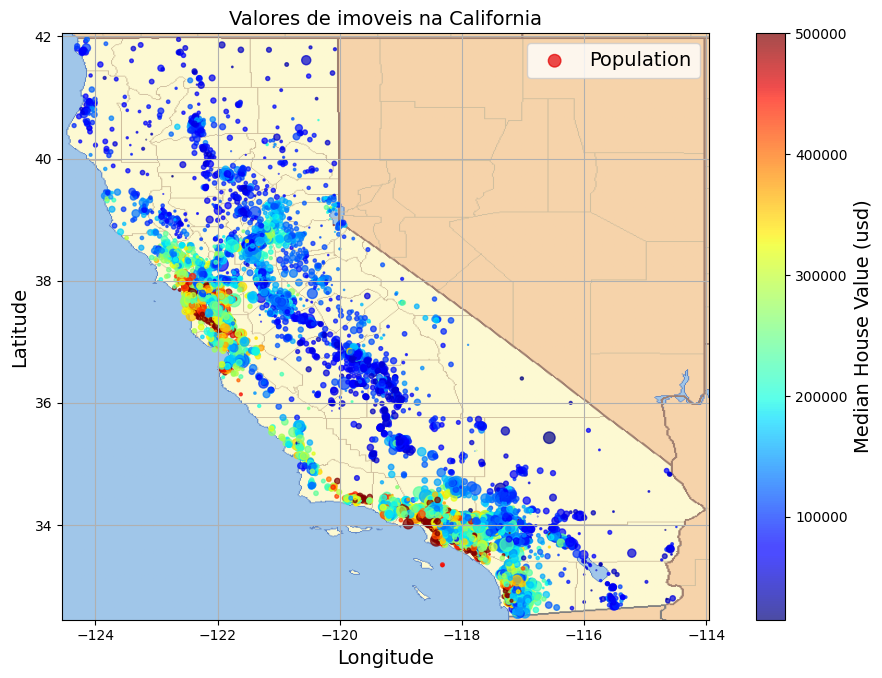

In [29]:
filename = 'california.png'
if not (IMAGES_PATH/filename).is_file():
    homl3_root="https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + 'images/end_to_end_project/'+filename
    # url = "https://github.com/ageron/handson-ml3/blob/main/images/end_to_end_project/california.png"
    print("Dowloanding, ",filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    'latitude':"Latitude",
    'longitude':"Longitude",
    'population': "Population",
    'median_house_value': "Median House Value (usd)"
})

housing_renamed.plot(kind='scatter', y='Latitude', x='Longitude',
                     grid=True, alpha=0.7, title='Valores de imoveis na California', 
                     s=housing_renamed['Population']/100, label='Population', figsize=(10,7),
                     c='Median House Value (usd)', cmap=plt.get_cmap('jet'),colorbar=True, 
                     legend=True,sharex=False)
california_img=plt.imread(IMAGES_PATH/filename)
# x_min, x_max = housing_renamed["Longitude"].min(), housing_renamed["Longitude"].max()
# y_min, y_max = housing_renamed["Latitude"].min(), housing_renamed["Latitude"].max()

# axis = (x_min, x_max,y_min, y_max)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
save_fig("california_housing_prices_plot")
plt.show()

Medindo correlação:

O coeficiente de correlação de Pearson (r) mede a força e a direção da **relação linear** entre duas variáveis numéricas.

Varia de -1 a +1.

+1: correlação perfeita positiva (uma cresce junto com a outra).

-1: correlação perfeita negativa (uma cresce enquanto a outra diminui).

0: não há relação linear.

O sinal indica a direção (positiva ou negativa) e o valor absoluto mostra a intensidade (quanto mais perto de 1, mais forte a relação).

É calculado a partir da covariância dividida pelos desvios-padrão das variáveis.

Atenção: correlação não significa causalidade.

In [30]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


#### Alta correlação entre o salario medio e o valor da casa

In [31]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

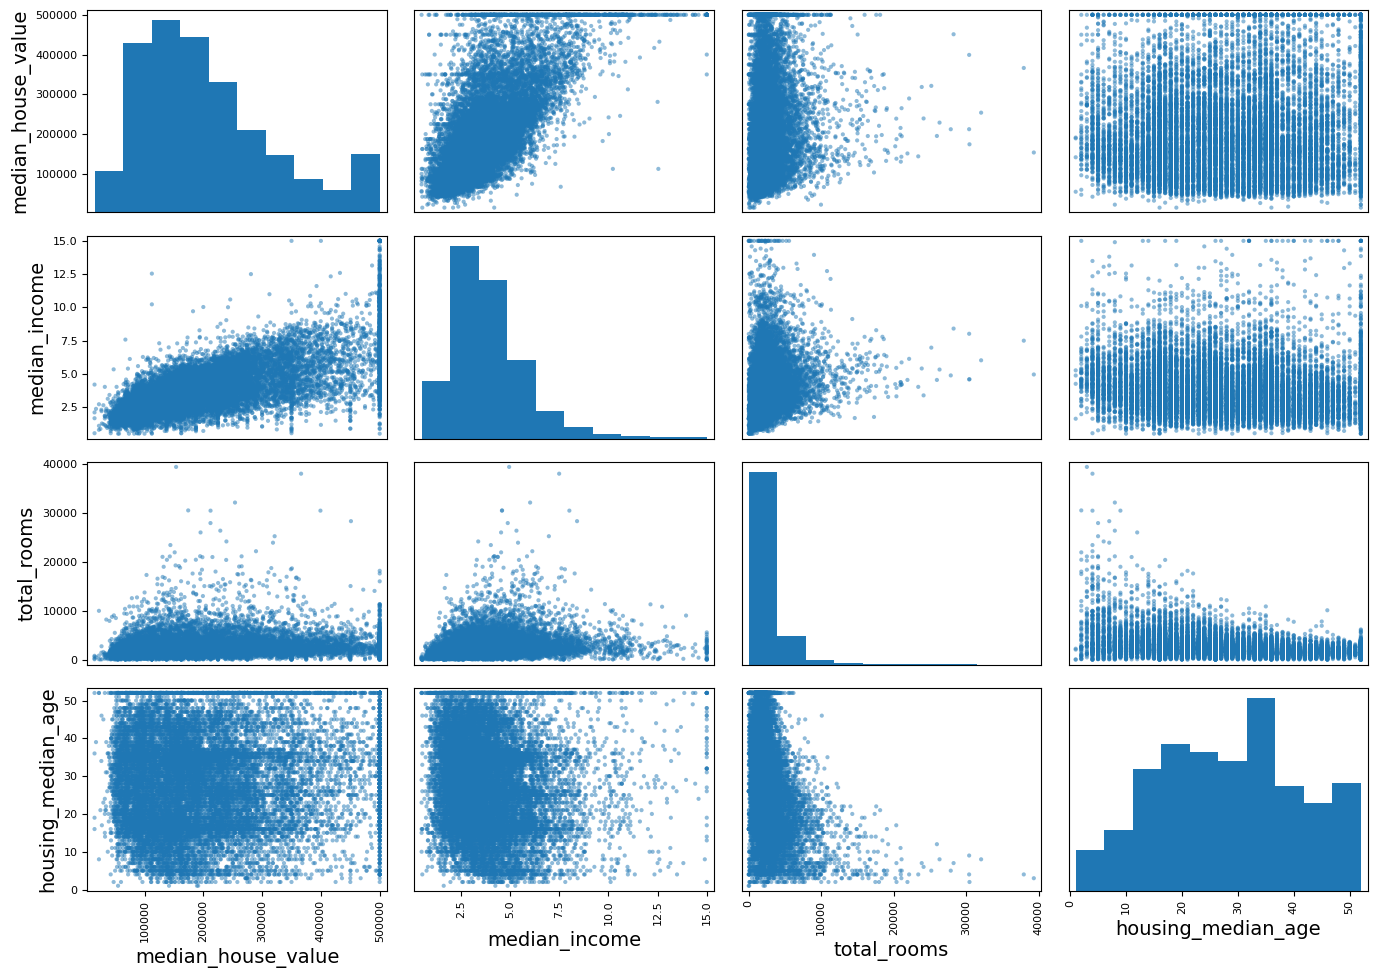

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(14,10))
save_fig("scatter_matrix_plot")
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

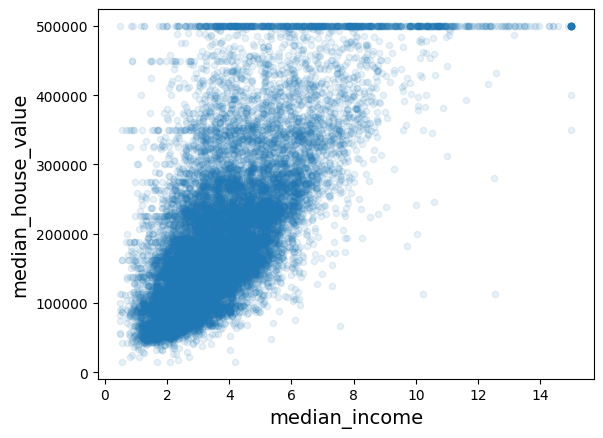

In [33]:

housing.plot(kind='scatter', y = 'median_house_value', x='median_income', alpha=0.1)

Observa-se uma forte correlação, os dados estao em uma reta ascendente e pouco dispersos.

Algumas tendencias horizontais podem ser vistas em 500mil, 470mil, 350mil e talvez entorno de 280mil.



__Testando outras combinações__

In [34]:
#Quantidade de comodos (rooms) por familia
housing["rooms_per_household"] = housing["total_rooms"]/housing['households']

#Quantidade de quartos por comodo
housing['bedrooms_per_room'] = housing["total_bedrooms"]/housing["total_rooms"]

#Quantidade de pessoas por familia
housing["population_per_household"] = housing['population']/housing["households"]
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,4.511933,0.230891,2.058473


In [35]:

corr_matrix = housing.corr(numeric_only=True)
corr_matrix


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859,-0.027899,0.087802,0.024587
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584,0.108037,-0.108871,-0.026457
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175,-0.153900,0.139119,0.012771
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455,0.128631,-0.183273,-0.037702
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635,0.001569,0.089931,-0.045017
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153,-0.076603,0.042698,0.085204
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426,-0.082242,0.072046,-0.042452
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380,0.314316,-0.619958,-0.006662
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000,0.143663,-0.256397,-0.038224
rooms_per_household,-0.027899,0.108037,-0.153900,0.128631,0.001569,-0.076603,-0.082242,0.314316,0.143663,1.000000,-0.402221,0.003868


In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

O numero de comodos por familia se mostrou mais correlacionado com o valor medio do que o numero total de comodos por bairro

__PREPARANDO OS DADOS__

In [37]:
X_train = strat_train_set.drop("median_house_value", axis=1)
Y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

__LIMPANDO OS DADOS__

Existem alguns dados que possuem valores faltando, algumas abordagens podem ser utilizadas: 
- remover os bairros
- remover todo o atributo em todos os bairros
- completar com algum valor

No dataset o atributo bedrooms esta faltando em algumas instancias

In [38]:
null_rows_idx = X_train.isnull().any(axis=1)
X_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [39]:
median = X_train["total_bedrooms"].median()
X_train["total_bedrooms"].fillna(median, inplace=True)

C:\Users\Alfredo\AppData\Local\Temp\ipykernel_22628\1334462342.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["total_bedrooms"].fillna(median, inplace=True)


In [40]:
X_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


__MEDIANA__

Foi utilizada a mediana para preencher o valores NaN presentes no atributo total_bedrooms. O metodo __.fillna()__ procura e substitui os valores NaN

__MANIPULANDO TEXTO E ATRIBUTOS CATEGORICOS (NOMINAIS)__

O modelo OneHotEncoder irá criar colunas extras para cada um dos possiveis atributos: ['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'] e irá mapear os bairros por 1 ou 0.

In [41]:
#A operação fit_ necessita de um DataFrame 2D
housing_cat = pd.DataFrame(X_train["ocean_proximity"])

housing_cat.head(9)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN


In [42]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)


In [43]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [44]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [45]:
#cat_encoder é o transformador que guarda as categorias aprendidas
#housing_cat_1hot é o resultado da transformação, uma matriz esparsa
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class Cat_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
        self.encoder = None  # será criado no fit

    def fit(self, X, y=None):
        self.encoder_ = OneHotEncoder(handle_unknown="ignore")
        self.encoder_.fit(X[[self.column_name]])
        return self
    
    def transform(self, X):
        return self.encoder_.transform(X[[self.column_name]])


In [47]:
test = Cat_Encoder("ocean_proximity")
encoded = test.fit_transform(X_train)

In [48]:
encoded.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

__Criando um transformador__

Acima vimos que algumas caracteristicas misturadas, rooms_per_household, bedrooms_per_room, population_per_household apresentado maior correlação com median_house_value do que alguns atributos.

O transformador vai permitir analisar a diferença entre usar essas caracteristicas extras

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# BaseEstimator e TransformerMixin → classes utilitárias do scikit-learn.

# BaseEstimator dá métodos úteis como get_params() e set_params().

# TransformerMixin já implementa o método fit_transform() automaticamente (baseado no seu fit e transform).

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
# Criamos uma classe herdando de BaseEstimator e TransformerMixin.

    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  #Nao faz nada
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(X_train.values)#.values converte para np

__Pipelines de Transformação__

In [50]:
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test.select_dtypes(include=[np.number])

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Metodo para lidar como valores NaN
imputer = SimpleImputer(strategy="median")


num_pipeline = Pipeline([
 ('imputer', imputer),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler())
])

X_train_num_tr = num_pipeline.fit_transform(X_train_num)

Criaremos um transformador para as colunas. Os transformadores trabalham com np 

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attributes_names].values

In [53]:
num_attribs = ((X_test_num).columns)
cat_attribs = "ocean_proximity"

In [54]:
#Definindo o Pipeline completo:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', imputer),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [55]:
from sklearn.pipeline import FeatureUnion

cat_pipeline = Pipeline([
    ('onehot', Cat_Encoder("ocean_proximity"))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [56]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [57]:
X_train_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 198144 stored elements and shape (16512, 16)>

__ESCALONAMENTO DE CARACTERISTICAS__

Algoritmos de Machine Learning não lidam bem com valores numericos que variem muito. Aplicar tecnicas de escalonamento são essenciais para manter uma escala fixa, alguns dos padroes mais usados são:
* min_max = os valores ficam fixos dentro de um intervalo (por exemplo de 0 a 1), mais sensivel a outliers
* padronização = os valores sao subtraidos da media e divide pela variancia (não fica preso a intervalos fixos), menos sensivel a outliers

In [58]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(X_train_num)

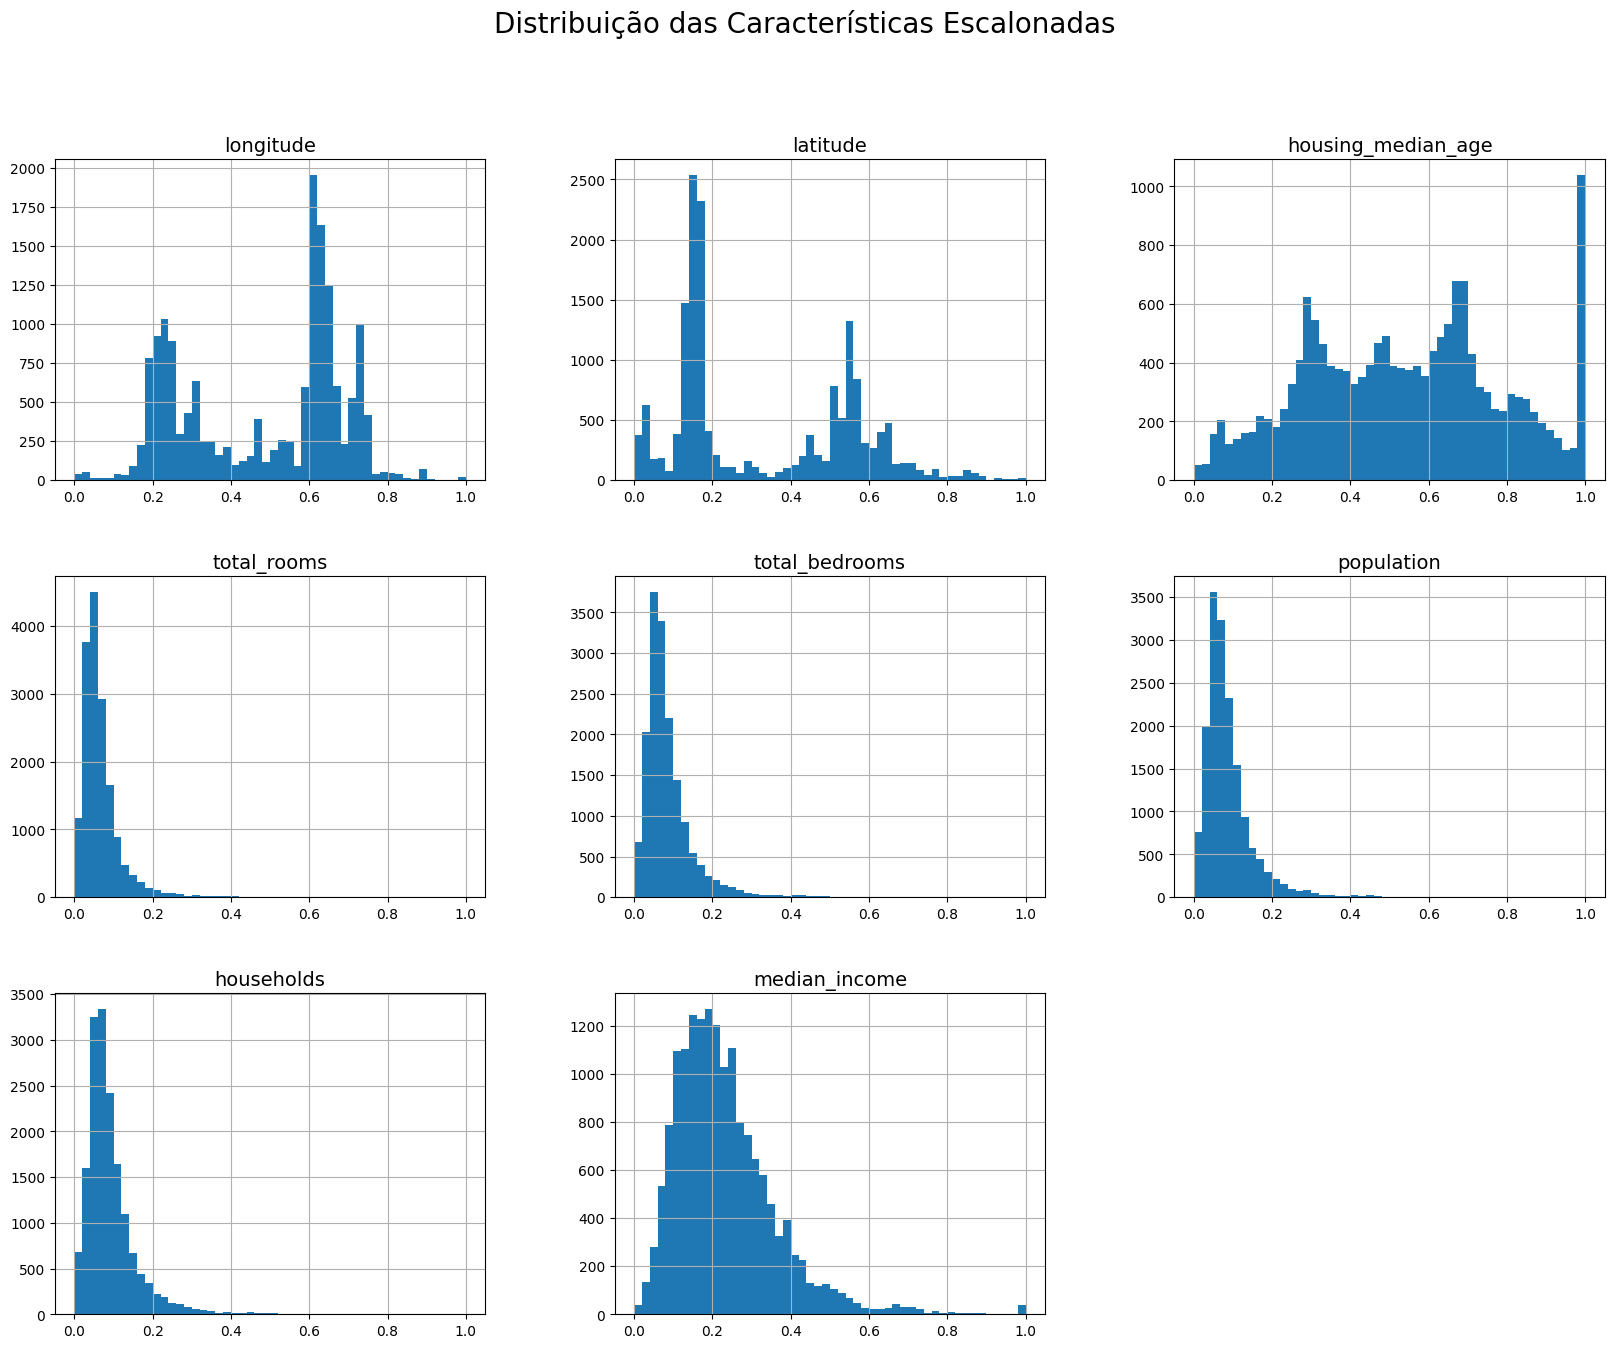

In [59]:
# Suponha que 'housing_num_min_max_scaled' é o seu array NumPy escalonado
# Para facilitar a visualização e nomear as colunas, converta-o de volta para um DataFrame do Pandas
housing_num_min_max_scaled_df = pd.DataFrame(housing_num_min_max_scaled, columns=X_train_num.columns)

# Crie um histograma para cada coluna
housing_num_min_max_scaled_df.hist(bins=50, figsize=(20, 15))

# Adicione título para o plot
plt.suptitle('Distribuição das Características Escalonadas', fontsize=20)

# Mostre o plot
plt.show()

StandardScaler: É uma classe do scikit-learn usada para padronizar as features (ou rótulos) subtraindo a média e dividindo pelo desvio padrão.

Esse é um metodo que evita predominancia de valores altos. Alguns modelos levam em consideração a magnitude dos numeros envolvidos, e isso ganha predominancia no modelo ao inves da interação entre o valores. A padronização retira essa influencia de tamanho e deixa todas as caracteristicas em escalas proporcionais.

In [60]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(X_train_num)

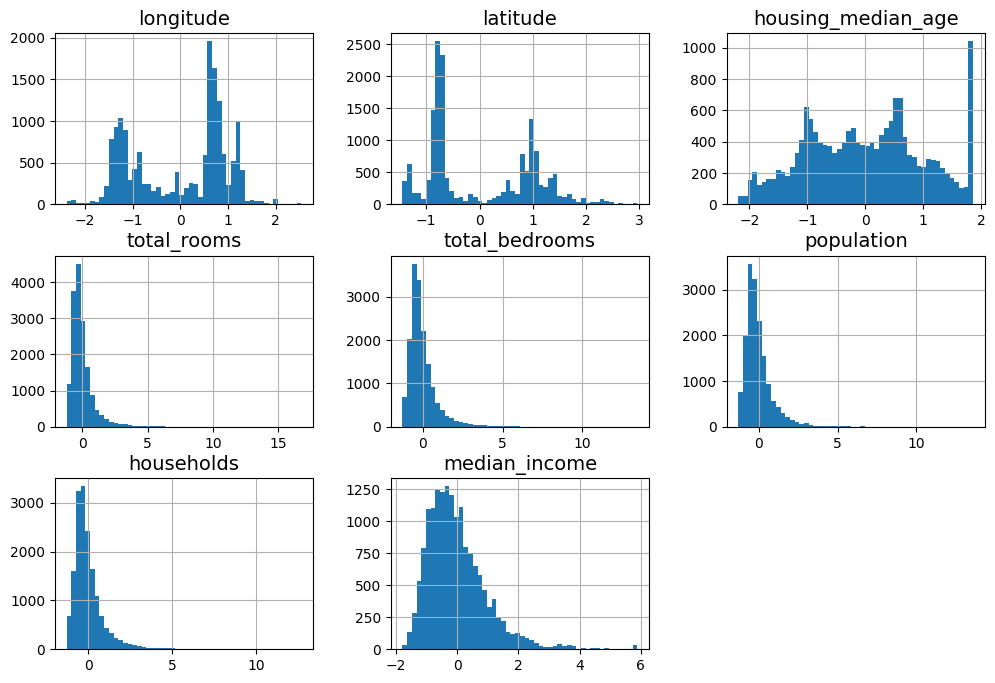

In [61]:
housing_num_std_scaled_pd = pd.DataFrame(housing_num_std_scaled, columns=X_train_num.columns)
housing_num_std_scaled_pd.hist(bins=50, figsize=(12,8))
plt.show()

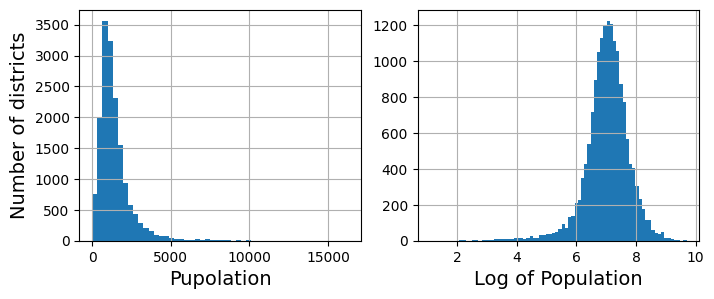

In [62]:
fig, axis = plt.subplots(1,2, figsize=(8,3))

X_train['population'].hist(ax=axis[0], bins=50)
X_train['population'].apply(np.log).hist(ax=axis[1], bins=80)

axis[0].set_xlabel("Pupolation")
axis[1].set_xlabel("Log of Population")
axis[0].set_ylabel("Number of districts")
plt.show()

Percebe-se que há uma assimetria para esquerda.Uma maior parte dos bairros possue uma população pequena, enquando uma pequena parte (a cauda) possui uma quantidade mais alta.

A função log "aperta" o intervalo e gera uma curva parecida com a distribuição normal

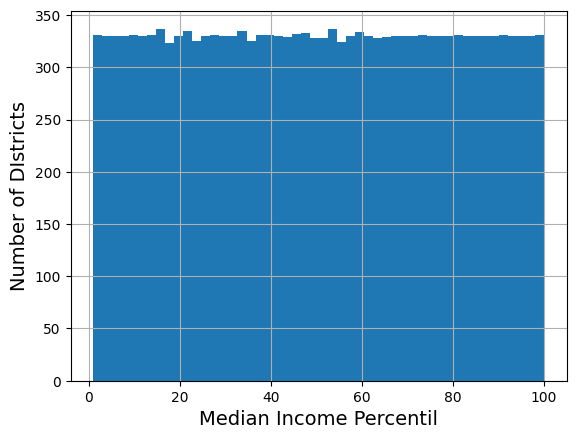

In [63]:
percentiles = [np.percentile(X_train["median_income"], p) for p in range(1,100)]

flattened_median_income =  pd.cut(X_train["median_income"], bins=[-np.inf] + percentiles + [np.inf], labels=range(1,100+1))

flattened_median_income.hist(bins= 50)

plt.xlabel("Median Income Percentil")
plt.ylabel("Number of DIstricts")
plt.show()

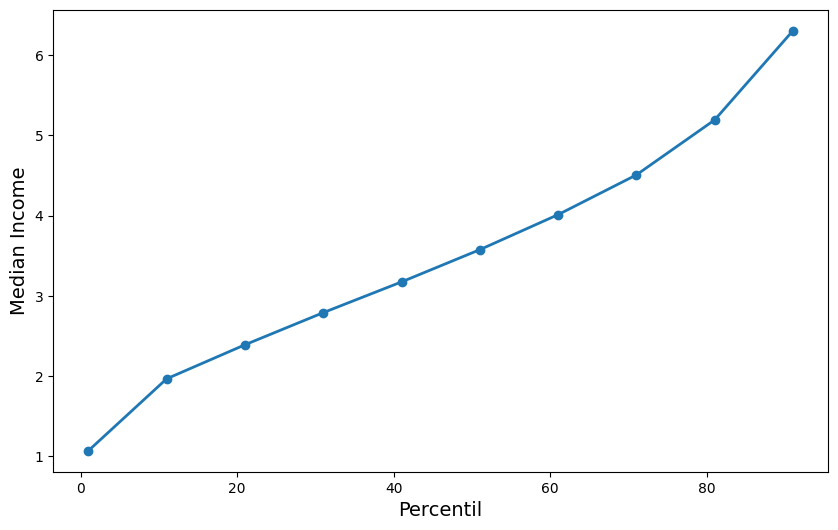

In [64]:
percentiles = [np.percentile(housing["median_income"], p) for p in range(1,101,10)]

labels_20 = [p for p in range(1,101,10)]

plt.figure(figsize=(10, 6))

plt.plot(
    labels_20,
    percentiles,
    marker='o',
    linestyle='-',
    linewidth=2
)

plt.xlabel("Percentil")
plt.ylabel("Median Income")
plt.show()

__Pipeline__: Aplicando pre processamento em sequencia no conjunto de dados

__Kernel da função de base radial (RBF)__

É uma função que mostra a similiaridade entre dois pontos baseada na distancia euclidiana entre eles:$$K(x, x') = \exp\left(-\frac{\|x - x'\|^2}{2\sigma^2}\right)$$

Sigma e gamma sao inversamente proporcionais: $$\gamma = 1/\sigma^2$$

A função RBF kernel é uma das mais usadas em máquinas de vetor de suporte (SVMs) e outros métodos de aprendizado de máquina.
Ela transforma os dados para um espaço de dimensão infinita de forma implícita, permitindo que o modelo aprenda fronteiras de decisão não lineares.

_Principais pontos:_

* Captura relações não lineares: ao medir a similaridade entre dois pontos pela distância euclidiana.

* Parâmetro γ: controla a influência de cada ponto.

    * γ grande → fronteiras mais complexas, risco de overfitting.

    * γ pequeno → fronteiras mais suaves, risco de underfitting.

* É universal: dado um conjunto de dados separável, sempre existe uma combinação que consegue separar.

* Usada principalmente em:

    * Classificação não linear (SVMs),

    * Regressão por kernel (SVR),

    * Métodos de clustering ou redução de dimensionalidade (como Kernel PCA).

In [65]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(X_train[['housing_median_age']], [[35]], gamma=0.01)

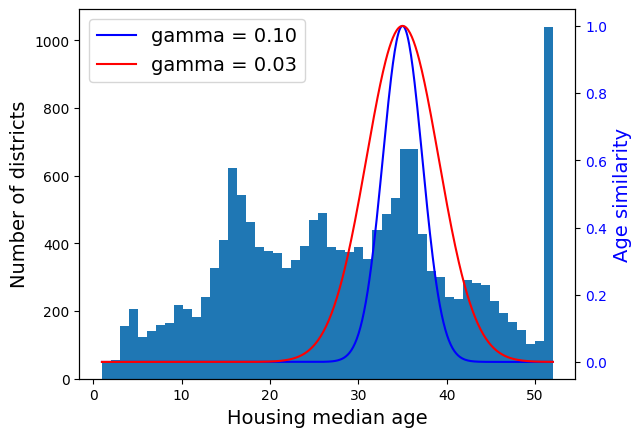

In [66]:
ages = np.linspace(X_train['housing_median_age'].min(), X_train['housing_median_age'].max(),500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages,[[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages,[[35]], gamma=gamma2)

fig, ax1 = plt.subplots()
ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(X_train["housing_median_age"], bins=50)

ax2 = ax1.twinx()#Crian um grafico que compartilha o mesmo eixo x e possui eixo y em oposição (no lado direito)
color = 'blue'
ax2.plot(ages, rbf1, color='blue', label="gamma = 0.10")
ax2.plot(ages, rbf2, color="red", label="gamma = 0.03")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
# save_fig("age_similarity_plot")
plt.show()

__Aplicando Regressao__


A diferença entre uma Series e um DataFrame é que uma serie é apenas uma coluna de valores indexados, porem um data frame é uma tabela que possui headers (tipo um objeto)

In [67]:
#Valores Medios separados: 

X_train#converter de Serie para DataFrame


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


Inicialmente aplica-se as tecnicas de normalização. Utilizadas em modelos de Machine Learning para facilitar a convergencia dos dados.

__StandardScaler__: É uma classe do scikit-learn usada para padronizar as features (ou rótulos) subtraindo a média e dividindo pelo desvio padrão.

In [68]:
# O modelo aprende os coeficientes (inclinação e intercepto) que minimizam o erro entre as previsões e
# os Y_train, enquanto eles estão na escala padronizada. Treinar com dados padronizados muitas vezes 
# melhora a convergência e o desempenho do modelo.

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [69]:
some_data = X_train.iloc[:5]
median_value = Y_train.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)


In [70]:
median_value.values.round(2)

array([458300., 483800., 101700.,  96100., 361800.])

In [71]:
predictions = lin_reg.predict(some_data_prepared).round(2)

Observa-se que ocorreu erro entre o resultado do modelo e os proprios dados de treinamento

In [72]:
from sklearn.metrics import root_mean_squared_error

rsme = root_mean_squared_error(median_value, predictions)
rsme

108430.67001819586

In [73]:
X_test_prepared = full_pipeline.transform(X_test)
predictions = lin_reg.predict(X_test_prepared)

In [74]:
prediction = pd.DataFrame({
    "Renda Media": X_test['median_income'],
    "Valor Aproximado": predictions.flatten().round(2),
    "Valor Real": Y_test,
    "Error%": ((Y_test - predictions.flatten())/Y_test)*100
})

In [75]:
prediction


,Renda Media,Valor Aproximado,Valor Real,Error%
3905,7.7360,383937.99,397700.0,3.460399
16821,4.6354,248549.73,202900.0,-22.498635
2900,4.0968,371354.82,310000.0,-19.791877
7193,4.1310,277098.02,314300.0,11.836457
13928,3.6037,235908.45,187500.0,-25.817839
...,...,...,...,...
12369,2.1135,176192.96,90600.0,-94.473466
8707,1.8289,96939.26,59400.0,-63.197402
16634,4.6875,259932.34,246200.0,-5.577717
9779,4.5721,228734.66,214700.0,-6.536872


In [76]:
from sklearn.metrics import root_mean_squared_error

rsme = root_mean_squared_error(Y_test, predictions)
rsme

71894.31217691506

A maioria das residencias encontra-se na faixa de 100mil a 200mil, um erro de 83mil não é aceitavel. Isso indica um subajuste, modelo fraco, ou muito restritivo, ou poucas caracteristicas.
Em seguida um modelo mais poderoso será tentado.

__Decision Tree__


In [77]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train_num, Y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [78]:
predictions_tree_model = tree_model.predict(X_train_num)

[Text(0.5, 0.875, 'median_income <= 5.032\nsquared_error = 13296524244.4\nsamples = 16512\nvalue = 206333.519'),
 Text(0.25, 0.625, 'median_income <= 3.106\nsquared_error = 8354716785.043\nsamples = 12991\nvalue = 172894.587'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'latitude <= 34.445\nsquared_error = 5612980442.247\nsamples = 6435\nvalue = 135978.932'),
 Text(0.0625, 0.125, 'squared_error = 5532552522.197\nsamples = 3115\nvalue = 157078.049'),
 Text(0.1875, 0.125, 'squared_error = 4878863659.837\nsamples = 3320\nvalue = 116182.623'),
 Text(0.375, 0.375, 'housing_median_age <= 38.5\nsquared_error = 8395310462.603\nsamples = 6556\nvalue = 209128.912'),
 Text(0.3125, 0.125, 'squared_error = 6874895649.419\nsamples = 5208\nvalue = 196418.103'),
 Text(0.4375, 0.125, 'squared_error = 11233611774.255\nsamples = 1348\nvalue = 258237.142'),
 Text(0.75, 0.625, 'median_income <= 6.818\nsquared_error = 12182641148.723\nsamples = 3521\nvalue = 329709.027'),
 Text(0.625, 0.75, '  False'

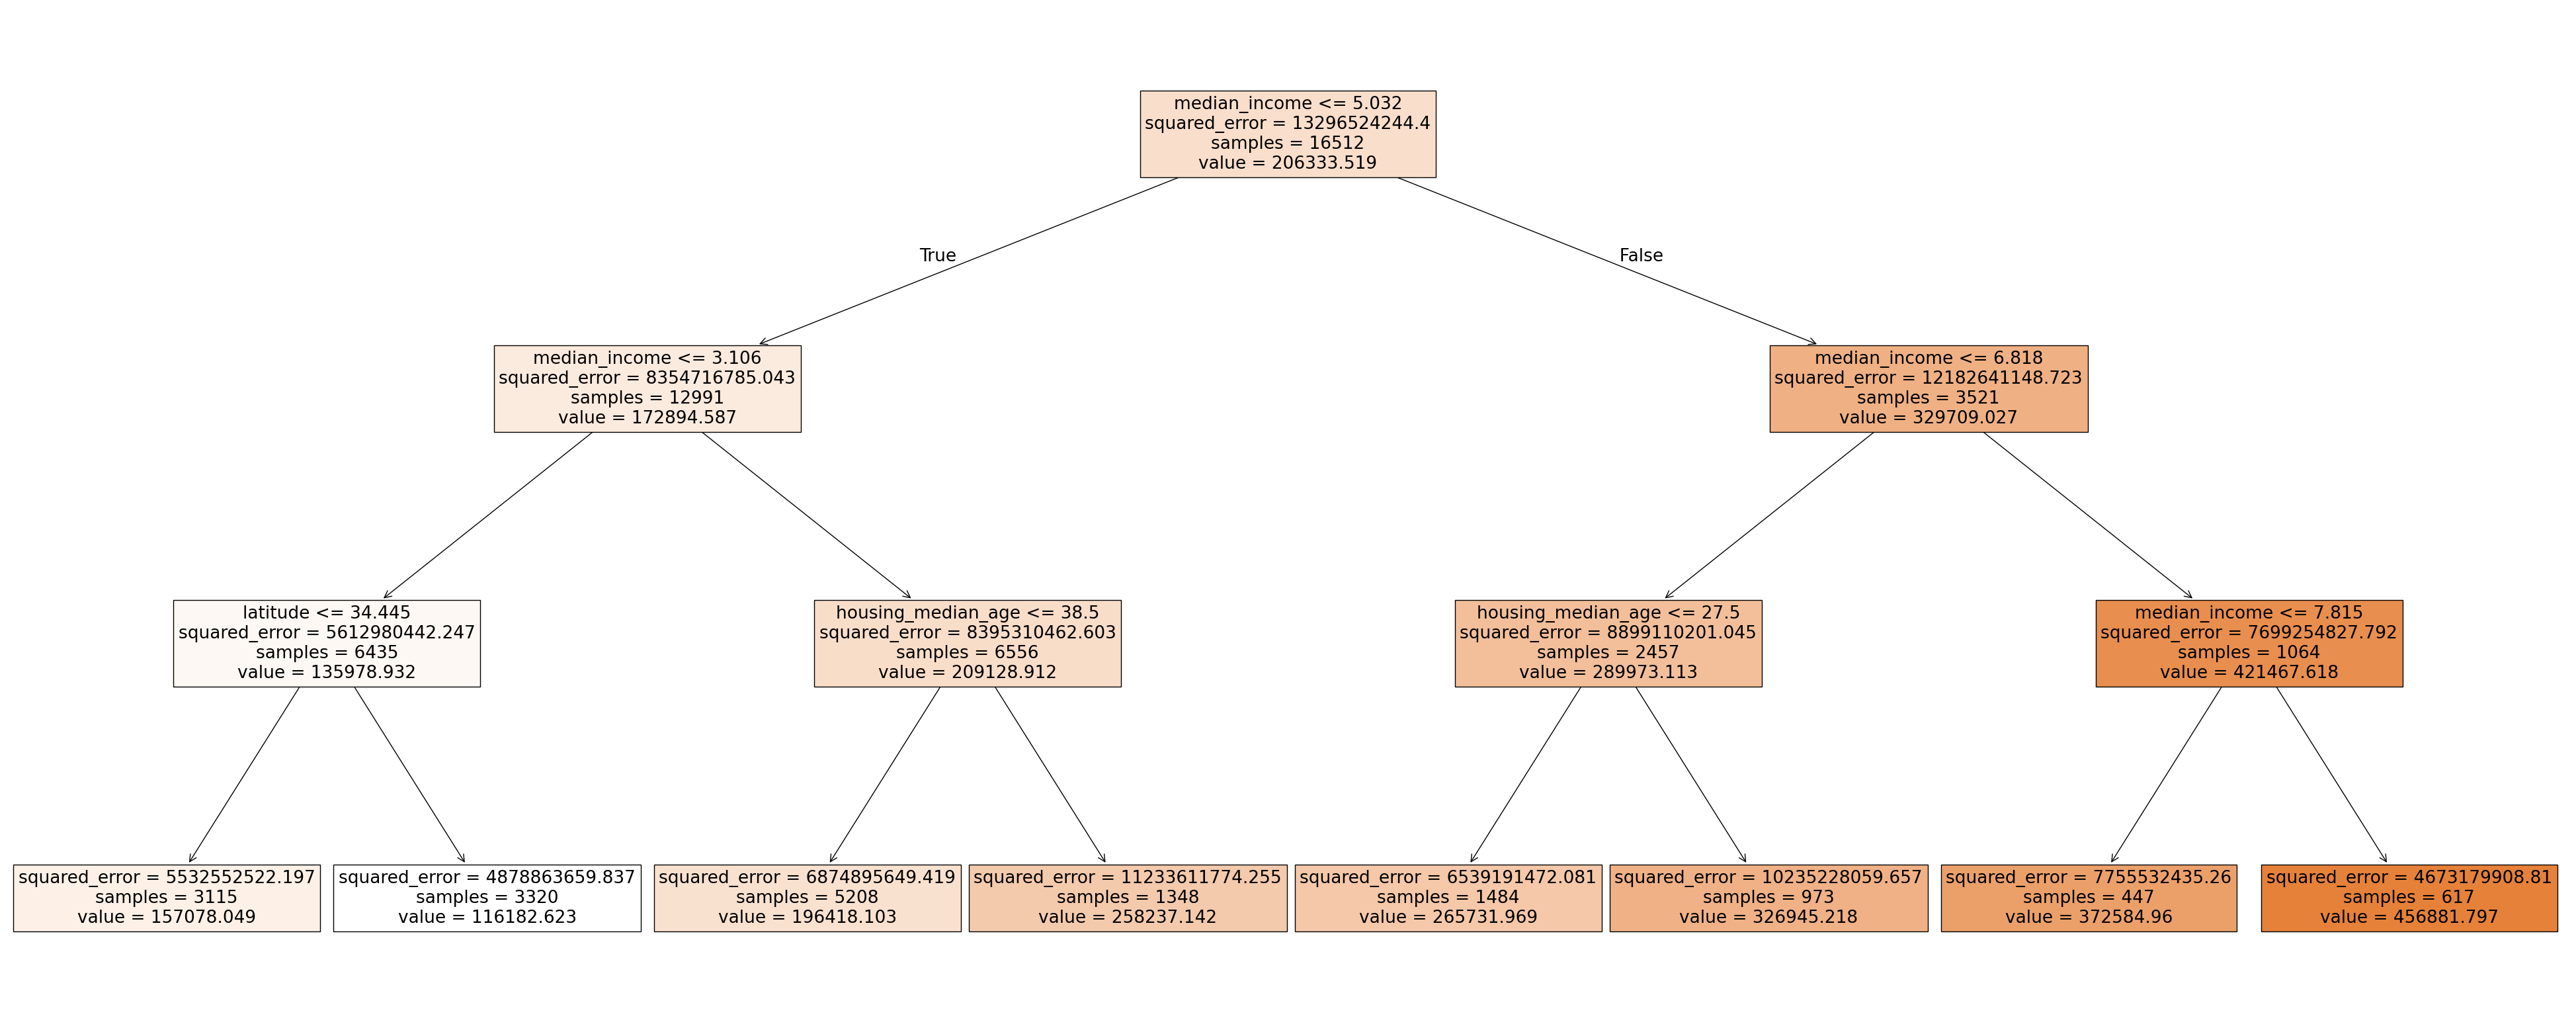

In [79]:
plt.figure(figsize=(50,20))
plot_tree(tree_model, feature_names=X_train_num.columns, filled=True)

In [80]:
prediction = pd.DataFrame({
    "Renda Media": X_train_num['median_income'],
    "Valor Aproximado": predictions_tree_model.flatten().round(2),
    "Valor Real": Y_train,
    "Error%": ((Y_train - predictions_tree_model.flatten())/Y_train)*100
})

In [81]:
prediction

,Renda Media,Valor Aproximado,Valor Real,Error%
13096,2.0987,116182.62,458300.0,74.649220
14973,6.0876,326945.22,483800.0,32.421410
3785,2.4330,116182.62,101700.0,-14.240534
14689,2.2618,157078.05,96100.0,-63.452704
20507,3.5292,196418.10,361800.0,45.710862
...,...,...,...,...
14207,4.7105,258237.14,500001.0,48.352675
13105,2.5733,116182.62,88800.0,-30.836287
19301,4.0616,196418.10,148800.0,-32.001413
19121,4.1455,196418.10,500001.0,60.716458


In [82]:
rsme = root_mean_squared_error(Y_train, predictions_tree_model)
rsme

81765.36231391964

No caso da DecisionTree o erro quadratico foi reduzido para zero ao testar nos dados de treinamento

__CROSS VALIDATION__ usando o algoritmo de validação cruzada é possivel verificar o resultado da Decision Tree.

O conjunto de treinamento é divido em varias partes aleatorios, e o algoritmo é testado em cada parte. O resultado é um array de pontuações

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
scores = cross_val_score(tree_model, X_train_prepared, Y_train, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)


In [84]:
pd.Series(tree_rmse_scores).describe()

count       10.000000
mean     69986.665039
std       2056.055803
min      66630.766858
25%      68712.704361
50%      69834.328460
75%      71232.213056
max      73458.425953
dtype: float64

Aplicando um divisao estratificada dos dados

In [85]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Divide os valores em n faixas de preço
Y_train_bins = pd.cut(Y_train, bins=5, labels=False)

scores = -cross_val_score(
    tree_model,           # modelo de classificação
    X_train_prepared, Y_train,          # features e labels
    cv=skfolds.split(X_train_prepared, Y_train_bins),
    scoring="neg_mean_squared_error"
)

pd.Series(np.sqrt(scores)).describe()

count       10.000000
mean     69621.678878
std       2231.169134
min      66111.196338
25%      68974.227980
50%      69859.443904
75%      70278.557219
max      73293.409531
dtype: float64

In [86]:
Y_train.describe()

count     16512.000000
mean     206333.518653
std      115314.047529
min       14999.000000
25%      119200.000000
50%      179200.000000
75%      263925.000000
max      500001.000000
Name: median_house_value, dtype: float64

Testa para o modelo linear

In [87]:
lin_score = -cross_val_score(lin_reg, X_train_prepared, Y_train, scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_score).describe()

count       10.000000
mean     67994.066868
std       1470.393731
min      66488.432066
25%      66859.125262
50%      67462.370465
75%      69330.436077
max      70478.224632
dtype: float64

Usando RandomForestRegressor

In [88]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_prepared, Y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
predictions = forest_reg.predict(X_train_prepared)

In [90]:
rms = root_mean_squared_error(predictions, Y_train)
rms

18453.431851360863

In [91]:
pd.Series(predictions).describe()

count     16512.000000
mean     206627.111493
std      108380.440247
min       34739.360000
25%      124701.500000
50%      183160.000000
75%      262510.757500
max      500001.000000
dtype: float64

In [92]:
Y_train.describe()

count     16512.000000
mean     206333.518653
std      115314.047529
min       14999.000000
25%      119200.000000
50%      179200.000000
75%      263925.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [93]:
predictions = forest_reg.predict(X_test_prepared)

In [94]:
rms = root_mean_squared_error(predictions, Y_test)
rms

50615.63460788509

In [95]:
pd.Series(predictions).describe()

count      4128.000000
mean     209729.875562
std      104081.903772
min       47414.000000
25%      130608.250000
50%      190320.000000
75%      267030.757500
max      500001.000000
dtype: float64

In [96]:
Y_test.describe()

count      4128.000000
mean     208945.009932
std      115711.735041
min       22500.000000
25%      120800.000000
50%      182150.000000
75%      268125.000000
max      500001.000000
Name: median_house_value, dtype: float64